When preprocessing and creating a model in a Machine Learning workflow, it is fundamental to ensure that every dataset is processed in the same way every time. To this extent, pipelines play a key role ensuring the same process for every dataset we want to import and use.

A pipeline can be defined as a sequence of objects that act on a set of data. The actions can include:

- apply transformations
- impute missing values (mean, median, zero, etc.)
- create a new feature
- fit a model
- predict on unseen data

The purpose of this is to validate the ML process. Indeed, whenever a part of the process changes, it is really useful to understand whether that change improved the performance or not. This could be the creation of a new feature or imputing missing values with the mean value of that feature rather than with zero. 

A trustable evaluation of the process is needed to get all this insights, else you will not be able to judge whether a specific change is improving or worsening your model performances. The definiton of a pipeline is fundamental to this extent, as repeating all those actions manually could easily lead to errors along the ML workflow.

First, let's import all the needed libraries and the dataset to be used:

In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import StratifiedShuffleSplit

from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

df_train_filepath = r'.\dataset\train.csv'
df_train = pd.read_csv(df_train_filepath)

df_test_filepath = r'.\dataset\test.csv'
df_test = pd.read_csv(df_test_filepath)

df_train.head()

def make_test(train, test_size, random_state, strat_feat=None):
    if strat_feat:
        
        split = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)

        for train_index, test_index in split.split(train, train[strat_feat]):
            train_set = train.loc[train_index]
            test_set = train.loc[test_index]
            
    return train_set, test_set

# Split the dataset while maintaining the proportion of 'Neighborhood'

train_set, test_set = make_test(df_train, 
                                test_size=0.2, random_state=654, 
                                strat_feat='Neighborhood')

print("\nTraining Set:\n", train_set)
print("\nTest Set:\n", test_set)

pd.set_option('display.max_columns', 500)


Training Set:
         Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
68      69          30       RM         47.0     4608   Pave   NaN      Reg   
1097  1098         120       RL          NaN     3696   Pave   NaN      Reg   
219    220         120       RL         43.0     3010   Pave   NaN      Reg   
901    902          20       RL         64.0     8712   Pave   NaN      IR1   
505    506          90       RM         60.0     7596   Pave  Grvl      Reg   
...    ...         ...      ...          ...      ...    ...   ...      ...   
1118  1119          80       RL         85.0    13825   Pave   NaN      Reg   
1308  1309          20       RM        100.0    12000   Pave   NaN      Reg   
563    564          50       RL         66.0    21780   Pave   NaN      Reg   
411    412         190       RL        100.0    34650   Pave   NaN      Reg   
15      16          45       RM         51.0     6120   Pave   NaN      Reg   

     LandContour Utilities LotConfi

Let's define the classes that are simple wrappers of already existing classes. We do this because using for example the SimpleImputer class, the output would be a numpy object while we want to keep the DataFrame object along our ML workflow. To this extent, customized classes can be defined as follows:

In [3]:
class general_cleaner(BaseEstimator, TransformerMixin):
    '''
    This class applies what we know from the documetation.
    It cleans some known missing values
    If flags the missing values

    This process is supposed to happen as first step of any pipeline
    '''
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        #LotFrontage
        X.loc[X.LotFrontage.isnull(), 'LotFrontage'] = 0
        #Alley
        X.loc[X.Alley.isnull(), 'Alley'] = "NoAlley"
        #MSSubClass
        X['MSSubClass'] = X['MSSubClass'].astype(str)
        #MissingBasement
        fil = ((X.BsmtQual.isnull()) & (X.BsmtCond.isnull()) & (X.BsmtExposure.isnull()) &
              (X.BsmtFinType1.isnull()) & (X.BsmtFinType2.isnull()))
        fil1 = ((X.BsmtQual.notnull()) | (X.BsmtCond.notnull()) | (X.BsmtExposure.notnull()) |
              (X.BsmtFinType1.notnull()) | (X.BsmtFinType2.notnull()))
        X.loc[fil1, 'MisBsm'] = 0
        X.loc[fil, 'MisBsm'] = 1 # made explicit for safety
        #BsmtQual
        X.loc[fil, 'BsmtQual'] = "NoBsmt" #missing basement
        #BsmtCond
        X.loc[fil, 'BsmtCond'] = "NoBsmt" #missing basement
        #BsmtExposure
        X.loc[fil, 'BsmtExposure'] = "NoBsmt" #missing basement
        #BsmtFinType1
        X.loc[fil, 'BsmtFinType1'] = "NoBsmt" #missing basement
        #BsmtFinType2
        X.loc[fil, 'BsmtFinType2'] = "NoBsmt" #missing basement
        #BsmtFinSF1
        X.loc[fil, 'BsmtFinSF1'] = 0 # No bsmt
        #BsmtFinSF2
        X.loc[fil, 'BsmtFinSF2'] = 0 # No bsmt
        #BsmtUnfSF
        X.loc[fil, 'BsmtUnfSF'] = 0 # No bsmt
        #TotalBsmtSF
        X.loc[fil, 'TotalBsmtSF'] = 0 # No bsmt
        #BsmtFullBath
        X.loc[fil, 'BsmtFullBath'] = 0 # No bsmt
        #BsmtHalfBath
        X.loc[fil, 'BsmtHalfBath'] = 0 # No bsmt
        #FireplaceQu
        X.loc[(X.Fireplaces == 0) & (X.FireplaceQu.isnull()), 'FireplaceQu'] = "NoFire" #missing
        #MisGarage
        fil = ((X.GarageYrBlt.isnull()) & (X.GarageType.isnull()) & (X.GarageFinish.isnull()) &
              (X.GarageQual.isnull()) & (X.GarageCond.isnull()))
        fil1 = ((X.GarageYrBlt.notnull()) | (X.GarageType.notnull()) | (X.GarageFinish.notnull()) |
              (X.GarageQual.notnull()) | (X.GarageCond.notnull()))
        X.loc[fil1, 'MisGarage'] = 0
        X.loc[fil, 'MisGarage'] = 1
        #GarageYrBlt
        X.loc[X.GarageYrBlt > 2200, 'GarageYrBlt'] = 2007 #correct mistake
        X.loc[fil, 'GarageYrBlt'] = 0
        #GarageType
        X.loc[fil, 'GarageType'] = "NoGrg" #missing garage
        #GarageFinish
        X.loc[fil, 'GarageFinish'] = "NoGrg" #missing
        #GarageQual
        X.loc[fil, 'GarageQual'] = "NoGrg" #missing
        #GarageCond
        X.loc[fil, 'GarageCond'] = "NoGrg" #missing
        #Fence
        X.loc[X.Fence.isnull(), 'Fence'] = "NoFence" #missing fence
        #Pool
        fil = ((X.PoolArea == 0) & (X.PoolQC.isnull()))
        X.loc[fil, 'PoolQC'] = 'NoPool' 
        
        del X['Id']
        del X['MiscFeature']
        del X['MSSubClass']
        del X['Neighborhood']  # this should be useful
        del X['Condition1']
        del X['Condition2']
        del X['ExterCond']  # maybe ordinal
        del X['Exterior1st']
        del X['Exterior2nd']
        del X['Functional']
        del X['Heating']
        del X['PoolQC']
        del X['RoofMatl']
        del X['RoofStyle']
        del X['SaleCondition']
        del X['SaleType']
        del X['Utilities']
        del X['BsmtCond']
        del X['Electrical']
        del X['Foundation']
        del X['Street']
        del X['Fence']
        del X['LandSlope']
        
        return X

class df_imputer(BaseEstimator, TransformerMixin):
    '''
    Just a wrapper for the SimpleImputer that keeps the dataframe structure
    '''
    def __init__(self, strategy='mean'):
        self.strategy = strategy
        self.imp = None
        self.statistics_ = None

    def fit(self, X, y=None):
        self.imp = SimpleImputer(strategy=self.strategy)
        self.imp.fit(X)
        self.statistics_ = pd.Series(self.imp.statistics_, index=X.columns)
        return self

    def transform(self, X):
        # X is supposed to be a DataFrame
        Ximp = self.imp.transform(X)
        Xfilled = pd.DataFrame(Ximp, index=X.index, columns=X.columns)
        return Xfilled
    
    
class df_scaler(BaseEstimator, TransformerMixin):
    '''
    Wrapper of StandardScaler or RobustScaler
    '''
    def __init__(self, method='standard'):
        self.scl = None
        self.scale_ = None
        self.method = method
        if self.method == 'sdandard':
            self.mean_ = None
        elif method == 'robust':
            self.center_ = None
        self.columns = None  # this is useful when it is the last step of a pipeline before the model

    def fit(self, X, y=None):
        if self.method == 'standard':
            self.scl = StandardScaler()
            self.scl.fit(X) # fit will learn the parameters needed to scale the data
            self.mean_ = pd.Series(self.scl.mean_, index=X.columns)
        elif self.method == 'robust':
            self.scl = RobustScaler()
            self.scl.fit(X) # fit will learn the parameters needed to scale the data
            self.center_ = pd.Series(self.scl.center_, index=X.columns)
        self.scale_ = pd.Series(self.scl.scale_, index=X.columns)
        return self

    def transform(self, X):
        # assumes X is a DataFrame, in such a way we applied the transform (scaling) while keeping the DataFrame
        #print(f"The previous saved columns during fit were: {self.scl.feature_names_in_}")
        #print(f"Now the columns used are: {X.columns}")
        # Compare the columns of the DataFrame with feature_names_in_
        #are_columns_equal = X.columns.equals(pd.Index(self.scl.feature_names_in_))
        #print("Columns match with feature_names_in_:", are_columns_equal)
        X = X.loc[:, self.scl.feature_names_in_]
        Xscl = self.scl.transform(X)
        
        #print(self.scl.feature_names_in_)
        Xscaled = pd.DataFrame(Xscl, index=X.index, columns=X.columns)
        self.columns = X.columns
        return Xscaled

    def get_feature_names(self):
        return list(self.columns)  # this is going to be useful when coupled with FeatureUnion
    

class dummify(BaseEstimator, TransformerMixin):
    '''
    Wrapper for get dummies, this is used to turn the categorical features into one-hot encodes.
    The different values of that feature will become new features. No need to fit anything. 
    '''
    def __init__(self, drop_first=False, match_cols=True):
        self.drop_first = drop_first
        self.columns = []  # useful to well behave with FeatureUnion
        self.match_cols = match_cols

    def fit(self, X, y=None):
        self.columns = []  # for safety, when we refit we want new columns
        return self
    
    def match_columns(self, X):
        miss_train = list(set(X.columns) - set(self.columns))
        miss_test = list(set(self.columns) - set(X.columns))
        
        err = 0
        
        if len(miss_test) > 0:
            for col in miss_test:
                X[col] = 0  # insert a column for the missing dummy
                err += 1
        if len(miss_train) > 0:
            for col in miss_train:
                del X[col]  # delete the column of the extra dummy
                err += 1
                
        if err > 0:
            warnings.warn('The dummies in this set do not match the ones in the train set, we corrected the issue.',
                         UserWarning) # this is to avoid that in the test dataset there are less dummies, this will take care of them assigning 0 to them, all this to not break the pipeline
        return X
    
        
    def transform(self, X):
        X = pd.get_dummies(X, drop_first=self.drop_first)
        if (len(self.columns) > 0): 
            if self.match_cols:
                X = self.match_columns(X)
            self.columns = X.columns
        else:
            self.columns = X.columns
        return X
    
    def get_features_name(self):
        return self.columns


The dummify class in machine learning is useful for encoding categorical features using one-hot encoding. Let's test it:

In [4]:
tmp = train_set[['HouseStyle']].copy()
dummifier = dummify()
tmp = dummifier.transform(tmp)
tmp.sample(5)

,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl
1398,True,False,False,False,False,False,False,False
1440,False,False,False,True,False,False,False,False
642,False,False,False,False,False,False,False,True
1423,False,False,False,False,False,False,False,True
783,False,False,False,False,False,False,True,False


Notice that, before the categorical variable HouseStyle had different values (1.5Fin, 1.5Unf, 1Story, etc.) and they have been one-hot encoded and turned into dummy variables.

Anyways, in every ML workflow mostly of the times the first transformer to be applied will likely be the imputer. The imputation method will change if dealing with numerical variables or categorical ones. Thus, the following class is to first split numerical and categorical variables into two subsets.

In [5]:
class feat_sel(BaseEstimator, TransformerMixin):
    '''
    This transformer selects either numerical or categorical features.
    In this way we can build separate pipelines for separate data types.
    '''
    def __init__(self, dtype='numeric'):
        self.dtype = dtype

    def fit( self, X, y=None ):
        return self 

    def transform(self, X, y=None):
        if self.dtype == 'numeric':
            num_cols = X.columns[X.dtypes != object].tolist()
            return X[num_cols]
        elif self.dtype == 'category':
            cat_cols = X.columns[X.dtypes == object].tolist()
            return X[cat_cols]

and in order to test it:

In [6]:
tmp = train_set.copy()
selector = feat_sel()  # it is numeric by default
tmp = selector.transform(tmp)  # no reason to fit again
tmp.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
68,69,30,47.0,4608,4,6,1945,1950,0.0,0,0,747,747,747,0,0,747,0,0,1,0,2,1,4,0,1945.0,1,220,0,0,0,0,0,0,0,6,2010,80000
1097,1098,120,NaN,3696,8,5,1986,1986,0.0,0,0,1074,1074,1088,0,0,1088,0,0,1,1,2,1,5,0,1987.0,2,461,0,74,137,0,0,0,0,10,2007,170000
219,220,120,43.0,3010,7,5,2005,2006,16.0,16,0,1232,1248,1248,0,0,1248,0,0,2,0,2,1,5,0,2005.0,2,438,108,0,0,0,0,0,0,3,2006,167240
901,902,20,64.0,8712,5,7,1957,2000,0.0,860,0,132,992,1306,0,0,1306,1,0,1,0,2,1,5,0,1968.0,1,756,0,0,0,0,0,0,0,5,2009,153000
505,506,90,60.0,7596,5,5,1952,1952,360.0,0,0,960,960,960,1000,0,1960,0,0,2,0,4,2,10,0,1952.0,2,400,0,0,0,0,0,0,0,7,2009,124500


Usually when working with categorical features some categories may be really rare, implying a mismatch in the dimension between test and train datasets. To take care of this issue, our dummify class will add the columns to not have any dimensional mismatch between train and test datasets. Let's try it out:

In [7]:
tmp = train_set[['RoofMatl']].copy()
dummifier = dummify()
dummifier.fit_transform(tmp).sum()

RoofMatl_ClyTile       1
RoofMatl_CompShg    1145
RoofMatl_Membran       1
RoofMatl_Roll          1
RoofMatl_Tar&Grv      11
RoofMatl_WdShake       3
RoofMatl_WdShngl       6
dtype: int64

but plotting out the test dataset, we can see that we do not have all those categories:

In [8]:
test_set.RoofMatl.value_counts()

RoofMatl
CompShg    289
WdShake      2
Metal        1
Name: count, dtype: int64

and dummifying this categorical variable would lead to creating just 4 columns, one for each category present. Though, the custom dummifier takes care of that in the following way:

In [9]:
tmp = test_set[['RoofMatl']].copy()
dummifier.transform(tmp).sum()

C:\Users\Rapaglia\AppData\Local\Temp\ipykernel_9328\646231096.py:198: UserWarning: The dummies in this set do not match the ones in the train set, we corrected the issue.
  warnings.warn('The dummies in this set do not match the ones in the train set, we corrected the issue.',


RoofMatl_CompShg    289
RoofMatl_WdShake      2
RoofMatl_Membran      0
RoofMatl_Roll         0
RoofMatl_ClyTile      0
RoofMatl_WdShngl      0
RoofMatl_Tar&Grv      0
dtype: int64

Now we are ready to create our customized pipeline to manage numerical features. Ideally, we want it to be as follows:
- cleaning the data
- impute some missing values with mean, median, etc.
- apply some transformation on some features
- create new features
- scale the data

First let's create a transformer for the numeric variables:

In [10]:
class tr_numeric(BaseEstimator, TransformerMixin):
    def __init__(self, SF_room=True):
        self.columns = []  # useful to well behave with FeatureUnion
        self.SF_room = SF_room
        

    def fit(self, X, y=None):
        return self
    

    def remove_skew(self, X, column):
        X[column] = np.log1p(X[column])
        return X


    def SF_per_room(self, X):
        if self.SF_room:
            X['sf_per_room'] = X['GrLivArea'] / X['TotRmsAbvGrd']
        return X
    

    def transform(self, X, y=None):
        for col in ['GrLivArea', '1stFlrSF', 'LotArea']: # they can also be inputs
            X = self.remove_skew(X, col)

        X = self.SF_per_room(X)
        
        self.columns = X.columns 
        return X
    

    def get_features_name(self):  # again, it will be useful later
        return self.columns

Please note that this transformer takes a parameter that determines whether or not to create a new feature. It is this kind of parameter that can be tuned with a GridSearch (more on this later).

Creating a new feature in that way would be impossible if the previous steps were not returning a DataFrame. There is naturally an alternative that includes specifying the index of the columns you want to use, but I find this approach way more user-friendly and robust.

A pipeline for numeric features would then look like this

In [11]:
numeric_pipe = Pipeline([('fs', feat_sel(dtype='numeric')),  # select only the numeric features
                         ('imputer', df_imputer(strategy='median')),  # impute the missing values with the median of each column
                         ('transf', tr_numeric(SF_room=True)),  # remove skew and create a new feature
                         ('scl', df_scaler(method='standard'))])  # scale the data

full_pipe = Pipeline([('gen_cl', general_cleaner()), ('num_pipe', numeric_pipe)])  # put the cleaner on top because we like it clean

In other words, with the use of the sklearn Pipeline, we want to sequentially apply the transformations in the given list. The list is made of tuples, the first element is a label for that step, and the second element is the transformation (or the model, or another pipeline). The name is useful to identify every parameter of the Pipeline, as we will see later.

This pipeline, given the training data, acts as follows

In [12]:
tmp = train_set.copy()
tmp = full_pipe.fit_transform(tmp)
tmp.head()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice,MisBsm,MisGarage,sf_per_room
68,-0.293799,-1.288747,-1.536497,0.388314,-0.854633,-1.687632,-0.572721,-0.951802,-0.289111,0.394816,-0.702008,-1.229020,-0.809847,-0.11994,-1.969786,-0.792460,-0.235213,-1.038946,-0.781445,-1.088870,-0.217078,-1.558394,-0.955475,0.166254,-1.023099,-1.176467,-0.743920,-0.700903,-0.360845,-0.114758,-0.275037,-0.070993,-0.08847,-0.090250,1.648787,-1.265526,-0.162364,-0.240772,1.837275
1097,-1.633589,-1.713701,1.365085,-0.520605,0.486653,0.054226,-0.572721,-0.951802,-0.289111,1.135134,0.034332,-0.047277,-0.809847,-0.11994,-0.843589,-0.792460,-0.235213,-1.038946,1.194156,-1.088870,-0.217078,-0.945737,-0.955475,0.259402,0.312074,-0.050133,-0.743920,0.408792,1.862782,-0.114758,-0.275037,-0.070993,-0.08847,1.384042,-0.612407,-0.145310,-0.162364,-0.240772,0.862474
219,-0.407824,-2.109283,0.639689,-0.520605,1.108225,1.021925,-0.482072,-0.917099,-0.289111,1.492841,0.426146,0.384011,-0.809847,-0.11994,-0.432573,-0.792460,-0.235213,0.791354,-0.781445,-1.088870,-0.217078,-0.945737,-0.955475,0.299323,0.312074,-0.157626,0.101091,-0.700903,-0.360845,-0.114758,-0.275037,-0.070993,-0.08847,-1.195969,-1.366138,-0.179663,-0.162364,-0.240772,0.966974
901,0.190806,-0.061418,-0.811101,1.297233,-0.462061,0.731615,-0.572721,0.913518,-0.289111,-0.997524,-0.150316,0.526820,-0.809847,-0.11994,-0.296476,1.147988,-0.235213,-1.038946,-0.781445,-1.088870,-0.217078,-0.945737,-0.955475,0.217264,-1.023099,1.328575,-0.743920,-0.700903,-0.360845,-0.114758,-0.275037,-0.070993,-0.08847,-0.458823,0.895056,-0.356906,-0.162364,-0.240772,1.001577
505,0.076781,-0.325582,-0.811101,-0.520605,-0.625633,-1.590862,1.466898,-0.951802,-0.289111,0.877042,-0.222373,-0.440678,1.464495,-0.11994,0.919993,-0.792460,-0.235213,0.791354,-0.781445,1.429547,4.154420,2.117548,-0.955475,0.181779,0.312074,-0.335222,-0.743920,-0.700903,-0.360845,-0.114758,-0.275037,-0.070993,-0.08847,0.278323,0.895056,-0.711641,-0.162364,-0.240772,-1.578772


In [13]:
tmp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1168 entries, 68 to 15
Data columns (total 39 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   LotFrontage    1168 non-null   float64
 1   LotArea        1168 non-null   float64
 2   OverallQual    1168 non-null   float64
 3   OverallCond    1168 non-null   float64
 4   YearBuilt      1168 non-null   float64
 5   YearRemodAdd   1168 non-null   float64
 6   MasVnrArea     1168 non-null   float64
 7   BsmtFinSF1     1168 non-null   float64
 8   BsmtFinSF2     1168 non-null   float64
 9   BsmtUnfSF      1168 non-null   float64
 10  TotalBsmtSF    1168 non-null   float64
 11  1stFlrSF       1168 non-null   float64
 12  2ndFlrSF       1168 non-null   float64
 13  LowQualFinSF   1168 non-null   float64
 14  GrLivArea      1168 non-null   float64
 15  BsmtFullBath   1168 non-null   float64
 16  BsmtHalfBath   1168 non-null   float64
 17  FullBath       1168 non-null   float64
 18  HalfBath      

As we wanted, the data flew through the pipeline, getting cleaned, transformed, and rescaled. Moreover, we still have a nice DataFrame structure.

The powerfulness of this pipeline is visible when we want to do the same thing to the validation set and it is evident when we implement it

In [14]:
tmp = test_set.copy()  # not ready to work on those sets yet
tmp = full_pipe.transform(tmp)  # the fit already happened with the training set, we don't want to fit again
tmp.head()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice,MisBsm,MisGarage,sf_per_room
787,0.532880,0.231473,0.639689,-0.520605,1.075511,0.925155,-0.572721,0.471047,-0.289111,-0.617178,-0.231381,-0.453800,1.755611,-0.11994,1.103831,1.147988,-0.235213,0.791354,1.194156,1.429547,-0.217078,0.892234,-0.955475,0.297105,0.312074,0.683620,-0.743920,-0.026089,-0.360845,-0.114758,-0.275037,-0.070993,-0.08847,-1.933115,1.648787,0.638841,-0.162364,-0.240772,-0.827150
284,-0.208281,-0.222833,-0.085706,-0.520605,0.682939,0.344536,-0.572721,-0.019142,-0.289111,1.295876,1.162487,1.115645,-0.809847,-0.11994,0.264671,1.147988,-0.235213,0.791354,-0.781445,-1.088870,-0.217078,-0.945737,-0.955475,0.270491,0.312074,0.267671,-0.743920,-0.700903,0.483160,-0.114758,-0.275037,-0.070993,-0.08847,0.278323,-0.612407,-0.030799,-0.162364,-0.240772,1.144248
184,0.988979,-0.366088,-0.811101,2.206152,-2.065062,0.296151,-0.572721,-0.951802,-0.289111,-0.155328,-1.249196,-0.520248,-0.091155,-0.11994,-0.422986,-0.792460,-0.235213,-1.038946,-0.781445,0.170338,-0.217078,-0.945737,-0.955475,0.257184,0.312074,0.487329,0.069795,-0.700903,-0.360845,-0.114758,-0.275037,-0.070993,-0.08847,-0.090250,-1.366138,-0.680524,-0.162364,-0.240772,0.969412
950,0.076781,-0.428758,-0.811101,2.206152,-0.691062,0.828385,-0.572721,-0.088549,0.621247,-0.578690,-0.438547,-0.771797,-0.809847,-0.11994,-1.534054,1.147988,-0.235213,-1.038946,-0.781445,0.170338,-0.217078,-0.945737,-0.955475,0.243877,0.312074,1.160326,0.773971,-0.700903,-0.360845,-0.114758,-0.275037,-0.070993,-0.08847,0.278323,-0.612407,-0.655630,-0.162364,-0.240772,0.686923
279,0.732423,0.205264,0.639689,-0.520605,0.192225,-0.381239,1.121296,-0.101563,-0.289111,0.442360,0.227988,0.143289,1.159733,-0.11994,1.013321,-0.792460,-0.235213,0.791354,1.194156,1.429547,-0.217078,0.892234,0.594518,0.237224,0.312074,0.155505,1.509443,1.053615,-0.360845,-0.114758,-0.275037,-0.070993,-0.08847,-1.195969,0.141325,0.128521,-0.162364,-0.240772,-0.841533


Along the pipeline the fit method is used by the scaler to get the parameters (mean value if StandardScaler, median value if RobustScaler) while the transform method is used to apply the transformation to the dataset. In all the ML applications when scaling the dataset to be used for training, it is important to keep in mind that the parameters have to be computed only on the training dataset and not including the testing dataset. This is done because computing the the mean value on the whole dataset would add an information about the testing data inside the training one, that is not what we want. We want to keep the testing data unseen and use it for inference! This is why when applying the pipeline to the testing dataset we do not want to fit again.

Though, the full pipeline will look like this:

In [15]:
full_pipe.get_params()

{'memory': None,
 'steps': [('gen_cl', general_cleaner()),
  ('num_pipe',
   Pipeline(steps=[('fs', feat_sel()), ('imputer', df_imputer(strategy='median')),
                   ('transf', tr_numeric()), ('scl', df_scaler())]))],
 'transform_input': None,
 'verbose': False,
 'gen_cl': general_cleaner(),
 'num_pipe': Pipeline(steps=[('fs', feat_sel()), ('imputer', df_imputer(strategy='median')),
                 ('transf', tr_numeric()), ('scl', df_scaler())]),
 'num_pipe__memory': None,
 'num_pipe__steps': [('fs', feat_sel()),
  ('imputer', df_imputer(strategy='median')),
  ('transf', tr_numeric()),
  ('scl', df_scaler())],
 'num_pipe__transform_input': None,
 'num_pipe__verbose': False,
 'num_pipe__fs': feat_sel(),
 'num_pipe__imputer': df_imputer(strategy='median'),
 'num_pipe__transf': tr_numeric(),
 'num_pipe__scl': df_scaler(),
 'num_pipe__fs__dtype': 'numeric',
 'num_pipe__imputer__strategy': 'median',
 'num_pipe__transf__SF_room': True,
 'num_pipe__scl__method': 'standard'}

Instead for categorical features:

In [16]:
class make_ordinal(BaseEstimator, TransformerMixin):
    '''
    Transforms ordinal features in order to have them as numeric (preserving the order)
    If unsure about converting or not a feature (maybe making dummies is better), make use of
    extra_cols and include_extra
    '''
    def __init__(self, cols, extra_cols=None, include_extra=True):
        self.cols = cols
        self.extra_cols = extra_cols
        self.mapping = {'Po':1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
        self.include_extra = include_extra
    

    def fit(self, X, y=None):
        return self
    

    def transform(self, X, y=None):
        if self.extra_cols:
            if self.include_extra:
                self.cols += self.extra_cols
            else:
                for col in self.extra_cols:
                    del X[col]
        
        for col in self.cols:
            X.loc[:, col] = X[col].map(self.mapping).fillna(0)
        return X

    
class recode_cat(BaseEstimator, TransformerMixin):        
    '''
    Recodes some categorical variables according to the insights gained from the
    data exploration phase. Not presented in this notebook
    '''
    def fit(self, X, y=None):
        return self
    
    
    def tr_GrgType(self, data):
        data['GarageType'] = data['GarageType'].map({'Basment': 'Attchd',
                                                  'CarPort': 'Detchd', 
                                                  '2Types': 'Attchd' }).fillna(data['GarageType'])
        return data
    
    
    def tr_LotShape(self, data):
        fil = (data.LotShape != 'Reg')
        data['LotShape'] = 1
        data.loc[fil, 'LotShape'] = 0
        return data
    
    
    def tr_LandCont(self, data):
        fil = (data.LandContour == 'HLS') | (data.LandContour == 'Low')
        data['LandContour'] = 0
        data.loc[fil, 'LandContour'] = 1
        return data
    
    
    def tr_LandSlope(self, data):
        fil = (data.LandSlope != 'Gtl')
        data['LandSlope'] = 0
        data.loc[fil, 'LandSlope'] = 1
        return data
    
    
    def tr_MSZoning(self, data):
        data['MSZoning'] = data['MSZoning'].map({'RH': 'RM', # medium and high density
                                                 'C (all)': 'RM', # commercial and medium density
                                                 'FV': 'RM'}).fillna(data['MSZoning'])
        return data
    
    
    def tr_Alley(self, data):
        fil = (data.Alley != 'NoAlley')
        data['Alley'] = 0
        data.loc[fil, 'Alley'] = 1
        return data
    
    
    def tr_LotConfig(self, data):
        data['LotConfig'] = data['LotConfig'].map({'FR3': 'Corner', # corners have 2 or 3 free sides
                                                   'FR2': 'Corner'}).fillna(data['LotConfig'])
        return data
    
    
    def tr_BldgType(self, data):
        data['BldgType'] = data['BldgType'].map({'Twnhs' : 'TwnhsE',
                                                 '2fmCon': 'Duplex'}).fillna(data['BldgType'])
        return data
    
    
    def tr_MasVnrType(self, data):
        data['MasVnrType'] = data['MasVnrType'].map({'BrkCmn': 'BrkFace'}).fillna(data['MasVnrType'])
        return data


    def tr_HouseStyle(self, data):
        data['HouseStyle'] = data['HouseStyle'].map({'1.5Fin': '1.5Unf', 
                                                         '2.5Fin': '2Story', 
                                                         '2.5Unf': '2Story', 
                                                         'SLvl': 'SFoyer'}).fillna(data['HouseStyle'])
        return data
    
    
    def transform(self, X, y=None):
        X = self.tr_GrgType(X)
        X = self.tr_LotShape(X)
        X = self.tr_LotConfig(X)
        X = self.tr_MSZoning(X)
        X = self.tr_Alley(X)
        X = self.tr_LandCont(X)
        X = self.tr_BldgType(X)
        X = self.tr_MasVnrType(X)
        X = self.tr_HouseStyle(X)
        return X

The pipeline for categorical features will then be

In [17]:
cat_pipe = Pipeline([('fs', feat_sel(dtype='category')),
                     ('imputer', df_imputer(strategy='most_frequent')), 
                     ('ord', make_ordinal(['BsmtQual', 'KitchenQual','GarageQual',
                                           'GarageCond', 'ExterQual', 'HeatingQC'])), 
                     ('recode', recode_cat()), 
                     ('dummies', dummify())])

full_pipe = Pipeline([('gen_cl', general_cleaner()), ('cat_pipe', cat_pipe)])

tmp = train_set.copy()
tmp = full_pipe.fit_transform(tmp)
tmp.head()

,Alley,LotShape,LandContour,MSZoning_RL,MSZoning_RM,LotConfig_Corner,LotConfig_CulDSac,LotConfig_Inside,BldgType_1Fam,BldgType_Duplex,BldgType_TwnhsE,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2Story,HouseStyle_SFoyer,MasVnrType_BrkFace,MasVnrType_Stone,ExterQual_2,ExterQual_3,ExterQual_4,ExterQual_5,BsmtQual_0.0,BsmtQual_2.0,BsmtQual_3.0,BsmtQual_4.0,BsmtQual_5.0,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtExposure_NoBsmt,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_NoBsmt,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_ALQ,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_NoBsmt,BsmtFinType2_Rec,BsmtFinType2_Unf,HeatingQC_1,HeatingQC_2,HeatingQC_3,HeatingQC_4,HeatingQC_5,CentralAir_N,CentralAir_Y,KitchenQual_2,KitchenQual_3,KitchenQual_4,KitchenQual_5,FireplaceQu_Ex,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_NoFire,FireplaceQu_Po,FireplaceQu_TA,GarageType_Attchd,GarageType_BuiltIn,GarageType_Detchd,GarageType_NoGrg,GarageFinish_Fin,GarageFinish_NoGrg,GarageFinish_RFn,GarageFinish_Unf,GarageQual_0.0,GarageQual_1.0,GarageQual_2.0,GarageQual_3.0,GarageQual_4.0,GarageQual_5.0,GarageCond_0.0,GarageCond_1.0,GarageCond_2.0,GarageCond_3.0,GarageCond_4.0,GarageCond_5.0,PavedDrive_N,PavedDrive_P,PavedDrive_Y
68,0,1,0,False,True,True,False,False,True,False,False,False,True,False,False,True,False,False,True,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,True,False,False,False,True,False,True,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,True,False,False,False,False,True
1097,0,1,0,True,False,False,False,True,False,False,True,False,True,False,False,True,False,False,False,True,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,True,False,True,False,False,True,False,False,False,False,True,False,False,True,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,True
219,0,1,0,True,False,False,False,True,False,False,True,False,True,False,False,True,False,False,False,True,False,False,False,False,True,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,True,False,False,True,False,False,False,False,True,False,False,True,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,True
901,0,0,0,True,False,False,False,True,True,False,False,False,True,False,False,True,False,False,True,False,False,False,False,True,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,True,False,True,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,True,False,False,False,True,False,False,False,False,False,True,False,False,False,False,True
505,1,1,0,False,True,False,False,True,False,True,False,False,False,True,False,True,False,False,True,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,True,False,False,True,False,True,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,True,False,False,False,True,False,False,False,False,False,True,False,False,True,False,False


And there we have it, some categories converted into numeric features, other first recoded and the dummified. This dataset is ready for a model and, as before, this pipeline is ready for the validation set as well

In [18]:
tmp = test_set.copy()
tmp = full_pipe.transform(tmp)
tmp.head()

C:\Users\Rapaglia\AppData\Local\Temp\ipykernel_9328\646231096.py:198: UserWarning: The dummies in this set do not match the ones in the train set, we corrected the issue.
  warnings.warn('The dummies in this set do not match the ones in the train set, we corrected the issue.',


,Alley,LotShape,LandContour,MSZoning_RL,MSZoning_RM,LotConfig_Corner,LotConfig_CulDSac,LotConfig_Inside,BldgType_1Fam,BldgType_Duplex,BldgType_TwnhsE,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2Story,HouseStyle_SFoyer,MasVnrType_BrkFace,MasVnrType_Stone,ExterQual_2,ExterQual_3,ExterQual_4,ExterQual_5,BsmtQual_0.0,BsmtQual_2.0,BsmtQual_3.0,BsmtQual_4.0,BsmtQual_5.0,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtExposure_NoBsmt,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_NoBsmt,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_ALQ,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_NoBsmt,BsmtFinType2_Rec,BsmtFinType2_Unf,HeatingQC_2,HeatingQC_3,HeatingQC_4,HeatingQC_5,CentralAir_N,CentralAir_Y,KitchenQual_2,KitchenQual_3,KitchenQual_4,KitchenQual_5,FireplaceQu_Ex,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_NoFire,FireplaceQu_Po,FireplaceQu_TA,GarageType_Attchd,GarageType_BuiltIn,GarageType_Detchd,GarageType_NoGrg,GarageFinish_Fin,GarageFinish_NoGrg,GarageFinish_RFn,GarageFinish_Unf,GarageQual_0.0,GarageQual_1.0,GarageQual_2.0,GarageQual_3.0,GarageQual_4.0,GarageCond_0.0,GarageCond_1.0,GarageCond_2.0,GarageCond_3.0,PavedDrive_N,PavedDrive_P,PavedDrive_Y,GarageCond_4.0,HeatingQC_1,GarageCond_5.0,GarageQual_5.0
787,0,0,0,True,False,False,False,True,True,False,False,False,False,True,False,True,False,False,False,True,False,False,False,False,True,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,True,False,False,True,False,False,False,False,True,False,False,False,True,False,False,False,False,True,False,False,False,False,True,False,False,False,False,True,False,False,True,0,0,0,0
284,0,1,0,True,False,False,False,True,False,False,True,False,True,False,False,True,False,False,False,True,False,False,False,False,True,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,True,False,False,True,False,False,False,False,True,False,False,True,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,True,False,False,True,0,0,0,0
184,0,0,0,True,False,False,False,True,True,False,False,True,False,False,False,True,False,False,True,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,True,False,False,True,False,True,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,True,False,False,True,0,0,0,0
950,0,1,0,True,False,False,False,True,True,False,False,False,True,False,False,True,False,False,True,False,False,False,False,True,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,True,False,False,True,False,False,False,False,True,False,False,False,False,True,False,False,False,True,False,False,False,False,True,False,False,False,False,True,False,False,True,0,0,0,0
279,0,1,0,True,False,False,False,True,True,False,False,False,False,True,False,True,False,False,True,False,False,False,False,False,True,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,True,False,True,False,False,False,False,False,False,False,True,True,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,True,False,False,True,0,0,0,0


In [19]:
full_pipe.get_params()

{'memory': None,
 'steps': [('gen_cl', general_cleaner()),
  ('cat_pipe',
   Pipeline(steps=[('fs', feat_sel(dtype='category')),
                   ('imputer', df_imputer(strategy='most_frequent')),
                   ('ord',
                    make_ordinal(cols=['BsmtQual', 'KitchenQual', 'GarageQual',
                                       'GarageCond', 'ExterQual', 'HeatingQC'])),
                   ('recode', recode_cat()), ('dummies', dummify())]))],
 'transform_input': None,
 'verbose': False,
 'gen_cl': general_cleaner(),
 'cat_pipe': Pipeline(steps=[('fs', feat_sel(dtype='category')),
                 ('imputer', df_imputer(strategy='most_frequent')),
                 ('ord',
                  make_ordinal(cols=['BsmtQual', 'KitchenQual', 'GarageQual',
                                     'GarageCond', 'ExterQual', 'HeatingQC'])),
                 ('recode', recode_cat()), ('dummies', dummify())]),
 'cat_pipe__memory': None,
 'cat_pipe__steps': [('fs', feat_sel(dtype='category

Now we are ready to put everything together. We have a pipeline for numeric features, one for categorical one, now we want a complete pipeline for the entire dataset.

Sklearn again helps us with FeatureUnion that, sadly, again compromises the DataFrame structure we are very much fun of. By now, we are confident enough to create our own version of it.

In [20]:
class FeatureUnion_df(TransformerMixin, BaseEstimator):
    '''
    Wrapper of FeatureUnion but returning a Dataframe, 
    the column order follows the concatenation done by FeatureUnion

    transformer_list: list of Pipelines

    '''
    def __init__(self, transformer_list, n_jobs=None, transformer_weights=None, verbose=False, **kwargs):
        self.transformer_list = transformer_list
        self.n_jobs = n_jobs
        self.transformer_weights = transformer_weights
        self.verbose = verbose  # these are necessary to work inside of GridSearch or similar
        self.kwargs = kwargs  # Capture extra arguments
        self.feat_un = FeatureUnion(self.transformer_list, 
                                    n_jobs=self.n_jobs, 
                                    transformer_weights=self.transformer_weights, 
                                    verbose=self.verbose,
                                    **self.kwargs) # to fix additional key words passed by grid search to FeatureUnion
        
    def fit(self, X, y=None):
        self.feat_un.fit(X)
        return self

    def transform(self, X, y=None):
        X_tr = self.feat_un.transform(X)
        columns = []
        
        for trsnf in self.transformer_list:
            cols = trsnf[1].steps[-1][1].get_features_name()  # getting the features name from the last step of each pipeline
            columns += list(cols)

        X_tr = pd.DataFrame(X_tr, index=X.index, columns=columns)
        
        return X_tr

    def get_params(self, deep=True):  # necessary to well behave in GridSearch
        return self.feat_un.get_params(deep=deep)

I hope it is now evident why I kept implementing a get_features_name method in the previous classes. It was all for this moment.

The complete pipeline will then be

In [21]:
numeric_pipe = Pipeline([('fs', feat_sel('numeric')),
                         ('imputer', df_imputer(strategy='median')),
                         ('transf', tr_numeric())])

cat_pipe = Pipeline([('fs', feat_sel('category')),
                     ('imputer', df_imputer(strategy='most_frequent')), 
                     ('ord', make_ordinal(['BsmtQual', 'KitchenQual','GarageQual',
                                           'GarageCond', 'ExterQual', 'HeatingQC'])), 
                     ('recode', recode_cat()), 
                     ('dummies', dummify())])

processing_pipe = FeatureUnion_df(transformer_list=[('cat_pipe', cat_pipe),
                                                 ('num_pipe', numeric_pipe)], )

full_pipe = Pipeline([('gen_cl', general_cleaner()), 
                      ('processing', processing_pipe), 
                      ('scaler', df_scaler())])  # the scaler is here to have also the ordinal features scaled

tmp = df_train.copy()
tmp = full_pipe.fit_transform(tmp)
tmp.head()

,Alley,LotShape,LandContour,MSZoning_RL,MSZoning_RM,LotConfig_Corner,LotConfig_CulDSac,LotConfig_Inside,BldgType_1Fam,BldgType_Duplex,BldgType_TwnhsE,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2Story,HouseStyle_SFoyer,MasVnrType_BrkFace,MasVnrType_Stone,ExterQual_2,ExterQual_3,ExterQual_4,ExterQual_5,BsmtQual_0.0,BsmtQual_2.0,BsmtQual_3.0,BsmtQual_4.0,BsmtQual_5.0,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtExposure_NoBsmt,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_NoBsmt,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_ALQ,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_NoBsmt,BsmtFinType2_Rec,BsmtFinType2_Unf,HeatingQC_1,HeatingQC_2,HeatingQC_3,HeatingQC_4,HeatingQC_5,CentralAir_N,CentralAir_Y,KitchenQual_2,KitchenQual_3,KitchenQual_4,KitchenQual_5,FireplaceQu_Ex,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_NoFire,FireplaceQu_Po,FireplaceQu_TA,GarageType_Attchd,GarageType_BuiltIn,GarageType_Detchd,GarageType_NoGrg,GarageFinish_Fin,GarageFinish_NoGrg,GarageFinish_RFn,GarageFinish_Unf,GarageQual_0.0,GarageQual_1.0,GarageQual_2.0,GarageQual_3.0,GarageQual_4.0,GarageQual_5.0,GarageCond_0.0,GarageCond_1.0,GarageCond_2.0,GarageCond_3.0,GarageCond_4.0,GarageCond_5.0,PavedDrive_N,PavedDrive_P,PavedDrive_Y,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice,MisBsm,MisGarage,sf_per_room
0,-0.257821,0.760512,-0.250182,0.518133,-0.518133,-0.523447,-0.262324,0.622762,0.443533,-0.245512,-0.347118,-0.360598,-0.994535,1.465112,-0.274063,0.309994,-0.309994,-0.098397,-1.278819,1.411313,-0.192177,-0.16125,-0.156721,-0.894565,1.167244,-0.300609,-0.422338,-0.317893,-0.291025,0.728285,-0.16125,-0.421212,-0.335864,1.578868,-0.231065,-0.16125,-0.316585,-0.646124,-0.114827,-0.152071,-0.098397,-0.180366,-0.16125,-0.195977,0.401865,-0.02618,-0.186352,-0.643994,-0.444638,0.985043,-0.263813,0.263813,-0.165667,-1.006873,1.221257,-0.271163,-0.129279,-0.152071,-0.593171,1.056382,-0.117851,-0.522385,0.794534,-0.253259,-0.610066,-0.24236,-0.56364,-0.24236,1.568348,-0.841191,-0.24236,-0.045376,-0.184376,0.337126,-0.098397,-0.045376,-0.24236,-0.069409,-0.156721,0.317893,-0.078757,-0.037037,-0.256307,-0.144841,0.299253,0.212877,-0.133270,0.651479,-0.517200,1.050994,0.878668,0.514104,0.575425,-0.288653,-0.944591,-0.459303,-0.803645,1.161852,-0.120242,0.529194,1.107810,-0.241061,0.789741,1.227585,0.163779,-0.211454,0.912210,-0.951226,0.296026,0.311725,0.351000,-0.752176,0.216503,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,-1.599111,0.138777,0.347273,-0.16125,-0.24236,-0.933787
1,-0.257821,0.760512,-0.250182,0.518133,-0.518133,1.910414,-0.262324,-1.605749,0.443533,-0.245512,-0.347118,-0.360598,1.005495,-0.682542,-0.274063,0.309994,-0.309994,-0.098397,0.781971,-0.708560,-0.192177,-0.16125,-0.156721,-0.894565,1.167244,-0.300609,-0.422338,3.145715,-0.291025,-1.373090,-0.16125,2.374103,-0.335864,-0.633365,-0.231065,-0.16125,-0.316585,-0.646124,-0.114827,-0.152071,-0.098397,-0.180366,-0.16125,-0.195977,0.401865,-0.02618,-0.186352,-0.643994,-0.444638,0.985043,-0.263813,0.263813,-0.165667,0.993174,-0.818829,-0.271163,-0.129279,-0.152071,-0.593171,-0.946628,-0.117851,1.914298,0.794534,-0.253259,-0.610066,-0.24236,-0.56364,-0.24236,1.568348,-0.841191,-0.24236,-0.045376,-0.184376,0.337126,-0.098397,-0.045376,-0.24236,-0.069409,-0.156721,0.317893,-0.078757,-0.037037,-0.256307,-0.144841,0.299253,0.645747,0.113413,-0.071836,2.179628,0.156734,-0.429577,-0.570750,1.171992,-0.288653,-0.641228,0.466465,0.418479,-0.795163,-0.120242,-0.381965,-0.819964,3.948809,0.789741,-0.761621,0.163779,-0.211454,-0.318683,0.600495,0.236495,0.311725,-0.060731,1.626195,-0.704483,-0.35

The order of the columns in our DataFrame object changed because FeatureUnion concatenated the results of each transformer.

Again, we can now apply the pipeline to the test set

In [22]:
tmp = test_set.copy()
tmp = full_pipe.transform(tmp)
tmp.head()

C:\Users\Rapaglia\AppData\Local\Temp\ipykernel_9328\646231096.py:198: UserWarning: The dummies in this set do not match the ones in the train set, we corrected the issue.
  warnings.warn('The dummies in this set do not match the ones in the train set, we corrected the issue.',


,Alley,LotShape,LandContour,MSZoning_RL,MSZoning_RM,LotConfig_Corner,LotConfig_CulDSac,LotConfig_Inside,BldgType_1Fam,BldgType_Duplex,BldgType_TwnhsE,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2Story,HouseStyle_SFoyer,MasVnrType_BrkFace,MasVnrType_Stone,ExterQual_2,ExterQual_3,ExterQual_4,ExterQual_5,BsmtQual_0.0,BsmtQual_2.0,BsmtQual_3.0,BsmtQual_4.0,BsmtQual_5.0,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtExposure_NoBsmt,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_NoBsmt,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_ALQ,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_NoBsmt,BsmtFinType2_Rec,BsmtFinType2_Unf,HeatingQC_1,HeatingQC_2,HeatingQC_3,HeatingQC_4,HeatingQC_5,CentralAir_N,CentralAir_Y,KitchenQual_2,KitchenQual_3,KitchenQual_4,KitchenQual_5,FireplaceQu_Ex,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_NoFire,FireplaceQu_Po,FireplaceQu_TA,GarageType_Attchd,GarageType_BuiltIn,GarageType_Detchd,GarageType_NoGrg,GarageFinish_Fin,GarageFinish_NoGrg,GarageFinish_RFn,GarageFinish_Unf,GarageQual_0.0,GarageQual_1.0,GarageQual_2.0,GarageQual_3.0,GarageQual_4.0,GarageQual_5.0,GarageCond_0.0,GarageCond_1.0,GarageCond_2.0,GarageCond_3.0,GarageCond_4.0,GarageCond_5.0,PavedDrive_N,PavedDrive_P,PavedDrive_Y,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice,MisBsm,MisGarage,sf_per_room
787,-0.257821,-1.314904,-0.250182,0.518133,-0.518133,-0.523447,-0.262324,0.622762,0.443533,-0.245512,-0.347118,-0.360598,-0.994535,1.465112,-0.274063,0.309994,-0.309994,-0.098397,-1.278819,1.411313,-0.192177,-0.16125,-0.156721,-0.894565,1.167244,-0.300609,-0.422338,-0.317893,-0.291025,0.728285,-0.16125,-0.421212,-0.335864,1.578868,-0.231065,-0.16125,-0.316585,-0.646124,-0.114827,-0.152071,-0.098397,-0.180366,-0.16125,-0.195977,0.401865,-0.02618,-0.186352,-0.643994,-0.444638,0.985043,-0.263813,0.263813,-0.165667,-1.006873,1.221257,-0.271163,-0.129279,-0.152071,-0.593171,1.056382,-0.117851,-0.522385,-1.258599,3.948533,-0.610066,-0.24236,-0.563640,-0.24236,1.568348,-0.841191,-0.24236,-0.045376,-0.184376,0.337126,-0.098397,-0.045376,-0.24236,-0.069409,-0.156721,0.317893,-0.078757,-0.037037,-0.256307,-0.144841,0.299253,0.530315,0.219595,0.651479,-0.517200,1.084115,0.927122,-0.570750,0.465762,-0.288653,-0.605006,-0.231281,-0.455843,1.789746,-0.120242,1.122524,1.107810,-0.241061,0.789741,1.227585,1.390023,-0.211454,0.91221,-0.951226,0.298231,0.311725,0.678514,-0.752176,-0.025067,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,-1.969111,1.645210,0.655778,-0.16125,-0.24236,-0.839652
284,-0.257821,0.760512,-0.250182,0.518133,-0.518133,-0.523447,-0.262324,0.622762,-2.254625,-0.245512,2.880862,-0.360598,1.005495,-0.682542,-0.274063,0.309994,-0.309994,-0.098397,-1.278819,1.411313,-0.192177,-0.16125,-0.156721,-0.894565,1.167244,-0.300609,-0.422338,-0.317893,-0.291025,0.728285,-0.16125,-0.421212,-0.335864,1.578868,-0.231065,-0.16125,-0.316585,-0.646124,-0.114827,-0.152071,-0.098397,-0.180366,-0.16125,-0.195977,0.401865,-0.02618,-0.186352,-0.643994,2.249020,-1.015184,-0.263813,0.263813,-0.165667,-1.006873,1.221257,-0.271163,-0.129279,-0.152071,-0.593171,1.056382,-0.117851,-0.522385,0.794534,-0.253259,-0.610066,-0.24236,-0.563640,-0.24236,1.568348,-0.841191,-0.24236,-0.045376,-0.184376,0.337126,-0.098397,-0.045376,-0.24236,-0.069409,-0.156721,0.317893,-0.078757,-0.037037,-0.256307,-0.144841,0.299253,-0.219993,-0.236171,-0.071836,-0.517200,0.686666,0.345679,-0.570750,-0.029915,-0.288653,1.307990,1.180172,1.116192,-0.795163,-0.120242,0.282523,1.107810,-0.241061,0.789741,-0.761621,-1.062465,-0.211454,-0.93413,-0.951226,0.271773,0.311725,0.262104,-0.752176,-0.704

This time, the parameters are a bit more complex

In [23]:
full_pipe.get_params()

{'memory': None,
 'steps': [('gen_cl', general_cleaner()),
  ('processing',
   FeatureUnion_df(transformer_list=[('cat_pipe',
                                      Pipeline(steps=[('fs',
                                                       feat_sel(dtype='category')),
                                                      ('imputer',
                                                       df_imputer(strategy='most_frequent')),
                                                      ('ord',
                                                       make_ordinal(cols=['BsmtQual',
                                                                          'KitchenQual',
                                                                          'GarageQual',
                                                                          'GarageCond',
                                                                          'ExterQual',
                                                                     

Having set up everything as we did, it is not difficult to tune our pipeline with GridSearch. We will put a simple model at the end of the pipeline just for the fun of it and tune both the hyperparameters of this model and the parameters of the pipeline.

We thus make use of GridSearch to pick the best model configuration by varying several parameters, namely

Whether or not we create the new feature describing the square feet per room
If we impute the numerical missing values with the mean or the median
If we drop one dummy or not
If we change the regularization parameter of the Lasso regression
Thanks to the fact that we have a pipeline, we are able to easily explore all these configurations without worrying too much about information leakage or by repeating the same steps over and over

In [24]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import KFold, GridSearchCV


folds = KFold(5, shuffle=True, random_state=541)

df_train['Target'] = np.log1p(df_train.SalePrice)

del df_train['SalePrice']

# Split the dataset while maintaining the proportion of 'Neighborhood'
train_set, test_set = make_test(df_train, 
                                test_size=0.2, random_state=654, 
                                strat_feat='Neighborhood')

y = train_set['Target'].copy()
del train_set['Target']

y_test = test_set['Target']
del test_set['Target']


def grid_search(data, target, estimator, param_grid, scoring, cv):
    
    grid = GridSearchCV(estimator=estimator, param_grid=param_grid, 
                        cv=cv, scoring=scoring, n_jobs=-1, return_train_score=False)
    
    pd.options.mode.chained_assignment = None  # this is because the gridsearch throws a lot of pointless warnings
    tmp = data.copy()
    grid = grid.fit(tmp, target)
    pd.options.mode.chained_assignment = 'warn'
    
    result = pd.DataFrame(grid.cv_results_).sort_values(by='mean_test_score', 
                                                        ascending=False).reset_index()
    
    del result['params']
    times = [col for col in result.columns if col.endswith('_time')]
    params = [col for col in result.columns if col.startswith('param_')]
    
    result = result[params + ['mean_test_score', 'std_test_score'] + times]
    
    return result, grid.best_params_

The grid search (here in an utility function just to have better looking results) looks like this

In [25]:
lasso_pipe = Pipeline([('gen_cl', general_cleaner()),
                       ('processing', processing_pipe),
                       ('scl', df_scaler()), 
                       ('lasso', Lasso(alpha=0.01))])

res, bp = grid_search(train_set, y, lasso_pipe, 
            param_grid={'processing__num_pipe__transf__SF_room': [True, False],  # here it is important to specify the values to try for the grid search algorithm
                        'processing__num_pipe__imputer__strategy': ['mean', 'median'],
                        'processing__cat_pipe__dummies__drop_first': [True, False],
                        'lasso__alpha': [0.1, 0.01, 0.001]},
            cv=folds, scoring='neg_mean_squared_error')

res

,param_lasso__alpha,param_processing__cat_pipe__dummies__drop_first,param_processing__num_pipe__imputer__strategy,param_processing__num_pipe__transf__SF_room,mean_test_score,std_test_score,mean_fit_time,std_fit_time,mean_score_time,std_score_time
0,0.010,True,mean,True,-0.020251,0.006768,0.120122,0.024351,0.078339,0.009873
1,0.010,True,mean,False,-0.020251,0.006768,0.135819,0.016176,0.062798,0.007360
2,0.010,True,median,True,-0.020251,0.006768,0.106702,0.005408,0.060914,0.006030
3,0.010,True,median,False,-0.020251,0.006768,0.112112,0.010142,0.064086,0.011099
4,0.010,False,median,True,-0.020298,0.006745,0.107434,0.007113,0.060154,0.003764
5,0.010,False,median,False,-0.020298,0.006745,0.109440,0.003397,0.063083,0.004974
6,0.010,False,mean,True,-0.020298,0.006745,0.105211,0.003543,0.060406,0.006562
7,0.010,False,mean,False,-0.020298,0.006745,0.110499,0.008408,0.059695,0.002493
8,0.001,True,mean,False,-0.020363,0.007705,0.142919,0.020591,0.058258,0.004279
9,0.001,True,median,False,-0.020365,0.007705,0.124867,0.016472,0.062662,0.009617


And the best parameters are

In [26]:
bp

{'lasso__alpha': 0.01,
 'processing__cat_pipe__dummies__drop_first': True,
 'processing__num_pipe__imputer__strategy': 'mean',
 'processing__num_pipe__transf__SF_room': True}

Please note how we refer to a specific parameter by calling every step of the pipeline by its name and concatenating those names by the double underscore.

We see from the GridSearch that, if we ignore the fact that these models are vey simple and not high-performing, the best configurations of parameters are scoring very similar results. One may want to be sure that the model is really the best possible one and/or it is predicting reasonable prices.

Thanks to all that effort in preserving the feature names and making sure that everything happens inside of the pipeline, this model will fit pretty much in any validation approach you might want to adopt.

For example, I might be interested in seeing how the model performs in a 5-fold cross-validation setting, I might want to see how much the predictions are off, if I am missing something in the data, what are the most important features. With a few helper functions, we are going to do all of it.

In [27]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

def cv_score(df_train, y_train, kfolds, pipeline):
    oof = np.zeros(len(df_train))
    train = df_train.copy()
    
    for train_index, test_index in kfolds.split(train.values):
            
        trn_data = train.iloc[train_index][:]
        val_data = train.iloc[test_index][:]
        
        trn_target = y_train.iloc[train_index].values.ravel()
        val_target = y_train.iloc[test_index].values.ravel()
        
        pipeline.fit(trn_data, trn_target)

        oof[test_index] = pipeline.predict(val_data).ravel()
            
    return oof


def get_coef(pipe):
    imp = pipe.steps[-1][1].coef_.tolist()
    feats = pipe.steps[-2][1].get_feature_names()  # again, this is why we implemented that method
    result = pd.DataFrame({'feat':feats,'score':imp})
    result = result.sort_values(by=['score'],ascending=False)
    return result

def _plot_diagonal(ax):
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    low = min(xmin, xmax)
    high = max(xmin, xmax)
    scl = (high - low) / 100
    
    line = pd.DataFrame({'x': np.arange(low, high ,scl), # small hack for a diagonal line
                         'y': np.arange(low, high ,scl)})
    ax.plot(line.x, line.y, color='black', linestyle='--')
    
    return ax


def plot_predictions(data, true_label, pred_label, feature=None, hue=None, legend=False):
    
    tmp = data.copy()
    tmp['Prediction'] = pred_label
    tmp['True Label'] = true_label
    tmp['Residual'] = tmp['True Label'] - tmp['Prediction']
    
    diag = False
    alpha = 0.7
    label = ''
    
    fig, ax = plt.subplots(1,2, figsize=(15,6))
    
    if feature is None:
        feature = 'True Label'
        diag = True
    else:
        legend = 'full'
        sns.scatterplot(x=feature, y='True Label', data=tmp, ax=ax[0], label='True',
                         hue=hue, legend=legend, alpha=alpha)
        label = 'Predicted'
        alpha = 0.4

    sns.scatterplot(x=feature, y='Prediction', data=tmp, ax=ax[0], label=label,
                         hue=hue, legend=legend, alpha=alpha)
    if diag:
        ax[0] = _plot_diagonal(ax[0])
    
    sns.scatterplot(x=feature, y='Residual', data=tmp, ax=ax[1], 
                    hue=hue, legend=legend, alpha=0.7)
    ax[1].axhline(y=0, color='r', linestyle='--')
    
    ax[0].set_title(f'{feature} vs Predictions')
    ax[1].set_title(f'{feature} vs Residuals')

lasso_oof = cv_score(train_set, y, folds, lasso_pipe)

lasso_oof[:10]

C:\Users\Rapaglia\AppData\Local\Temp\ipykernel_9328\646231096.py:198: UserWarning: The dummies in this set do not match the ones in the train set, we corrected the issue.
  warnings.warn('The dummies in this set do not match the ones in the train set, we corrected the issue.',
C:\Users\Rapaglia\AppData\Local\Temp\ipykernel_9328\646231096.py:198: UserWarning: The dummies in this set do not match the ones in the train set, we corrected the issue.
  warnings.warn('The dummies in this set do not match the ones in the train set, we corrected the issue.',
C:\Users\Rapaglia\AppData\Local\Temp\ipykernel_9328\646231096.py:198: UserWarning: The dummies in this set do not match the ones in the train set, we corrected the issue.
  warnings.warn('The dummies in this set do not match the ones in the train set, we corrected the issue.',
C:\Users\Rapaglia\AppData\Local\Temp\ipykernel_9328\646231096.py:198: UserWarning: The dummies in this set do not match the ones in the train set, we corrected the is

array([11.32522959, 12.00673141, 12.09831085, 11.86418002, 11.78996038,
       12.59166372, 12.59961651, 12.36724328, 12.2128648 , 12.11441632])

We have our predictions and we can see the coefficients of our regression

In [28]:
get_coef(lasso_pipe)

,feat,score
98,GrLivArea,0.117075
86,OverallQual,0.100866
88,YearBuilt,0.053780
108,GarageCars,0.047323
87,OverallCond,0.034387
...,...,...
50,CentralAir_N,-0.009329
53,KitchenQual_3,-0.009606
18,ExterQual_3,-0.009897
59,FireplaceQu_NoFire,-0.012790


From the coefficients we can appreciate that GrLivArea and OverallQual have an higher impact on the SalePrice than the other features.

Now we want to see if the predictions are too far off or if there is something odd in the residual plot (I suggest to read about them as they are very useful tools for diagnosing something wrong in your model)

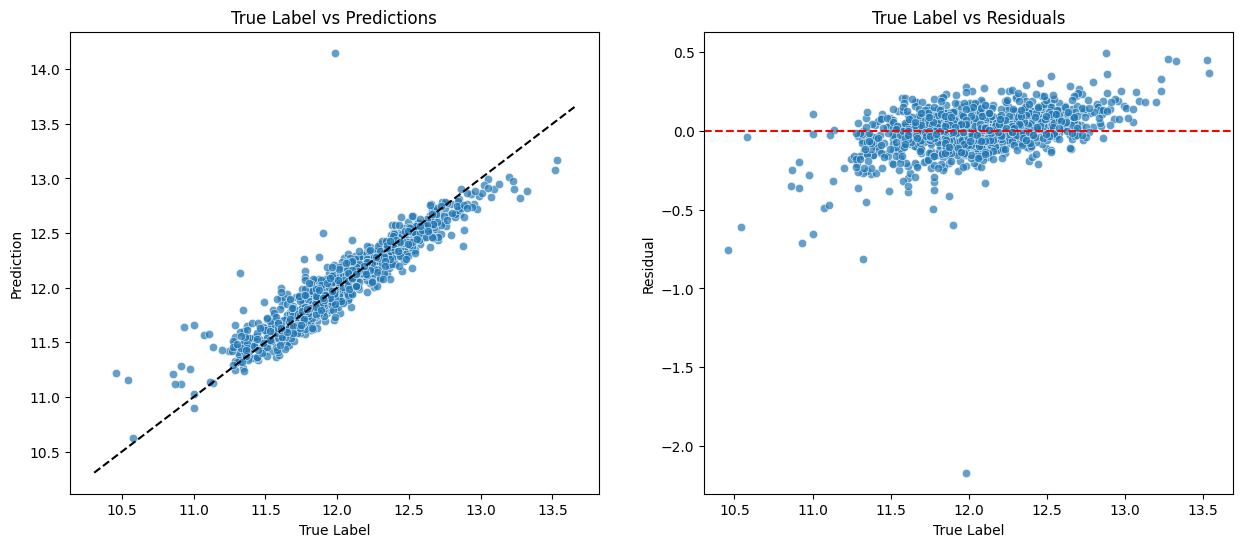

In [29]:
plot_predictions(train_set, y, lasso_oof)

There is a big outlier in our prediction and a visible pattern in the residual plot, both things that would require further investigation.

We can also plot the residuals against the most important features, for example

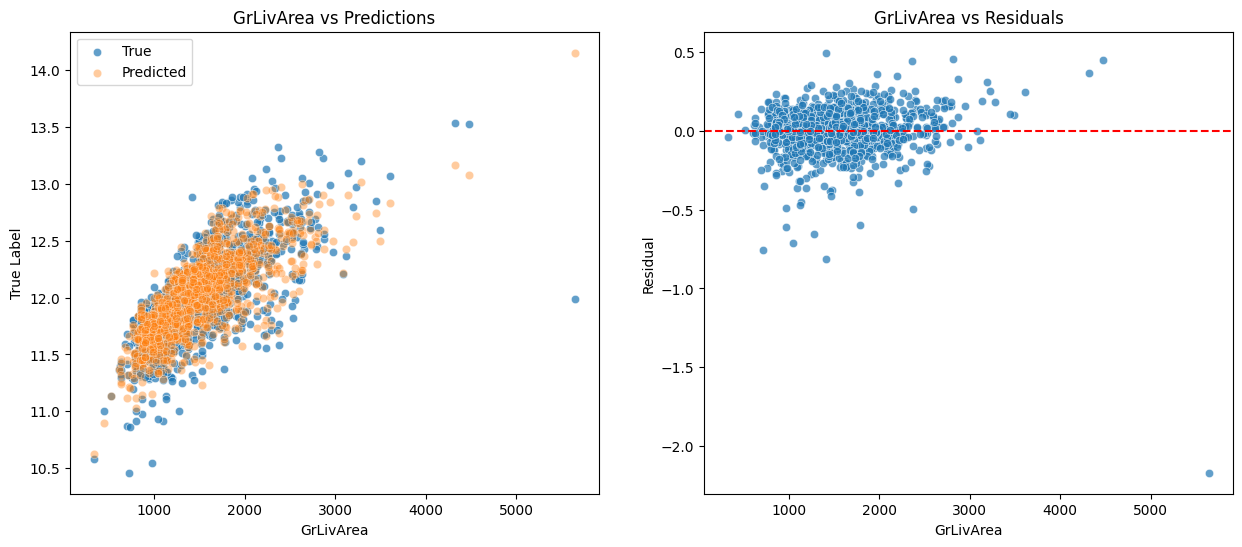

In [30]:
plot_predictions(train_set, y, lasso_oof, feature='GrLivArea')

And there we find that our prediction so much off with respect to the real value was indeed a house too cheap for its size (to be fair, this is one of the outliers that everybody know about and they are documented in the official documentation).

So far, we have used the default parameters of our pipeline but we know that there is a better configuration thanks to our GridSearch. Let's see if something changes.

In [31]:
numeric_pipe = Pipeline([('fs', feat_sel('numeric')),
                         ('imputer', df_imputer(strategy='mean')),  # tuned above
                         ('transf', tr_numeric(SF_room=True))])  # tuned above


cat_pipe = Pipeline([('fs', feat_sel('category')),
                     ('imputer', df_imputer(strategy='most_frequent')), 
                     ('ord', make_ordinal(['BsmtQual', 'KitchenQual','GarageQual',
                                           'GarageCond', 'ExterQual', 'HeatingQC'])), 
                     ('recode', recode_cat()), 
                     ('dummies', dummify(drop_first=True))])  # tuned above


processing_pipe = FeatureUnion_df(transformer_list=[('cat_pipe', cat_pipe),
                                                    ('num_pipe', numeric_pipe)])

lasso_pipe = Pipeline([('gen_cl', general_cleaner()), 
                 ('processing', processing_pipe),
                  ('scl', df_scaler()), ('lasso', Lasso(alpha=0.01))])  # tuned above

lasso_oof = cv_score(train_set, y, folds, lasso_pipe)

get_coef(lasso_pipe)

C:\Users\Rapaglia\AppData\Local\Temp\ipykernel_9328\646231096.py:198: UserWarning: The dummies in this set do not match the ones in the train set, we corrected the issue.
  warnings.warn('The dummies in this set do not match the ones in the train set, we corrected the issue.',
C:\Users\Rapaglia\AppData\Local\Temp\ipykernel_9328\646231096.py:198: UserWarning: The dummies in this set do not match the ones in the train set, we corrected the issue.
  warnings.warn('The dummies in this set do not match the ones in the train set, we corrected the issue.',
C:\Users\Rapaglia\AppData\Local\Temp\ipykernel_9328\646231096.py:198: UserWarning: The dummies in this set do not match the ones in the train set, we corrected the issue.
  warnings.warn('The dummies in this set do not match the ones in the train set, we corrected the issue.',
C:\Users\Rapaglia\AppData\Local\Temp\ipykernel_9328\646231096.py:198: UserWarning: The dummies in this set do not match the ones in the train set, we corrected the is

,feat,score
79,GrLivArea,0.117398
67,OverallQual,0.100781
69,YearBuilt,0.053509
89,GarageCars,0.047343
68,OverallCond,0.034437
...,...,...
12,ExterQual_3,-0.009719
40,KitchenQual_3,-0.009734
45,FireplaceQu_NoFire,-0.013077
28,BsmtFinType1_Unf,-0.015298


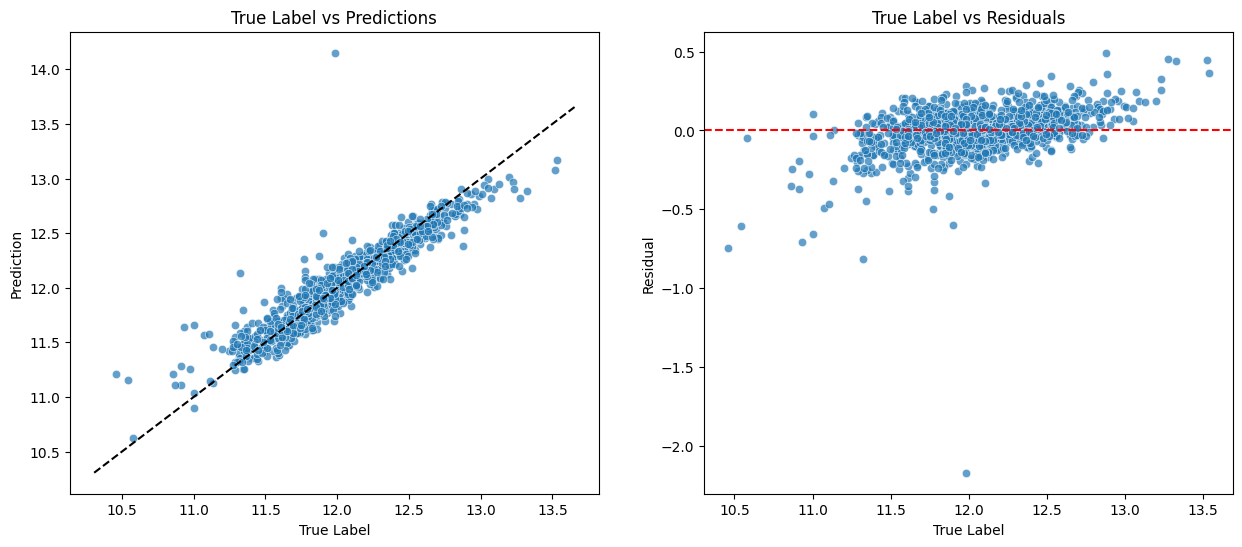

In [32]:
plot_predictions(train_set, y, lasso_oof)

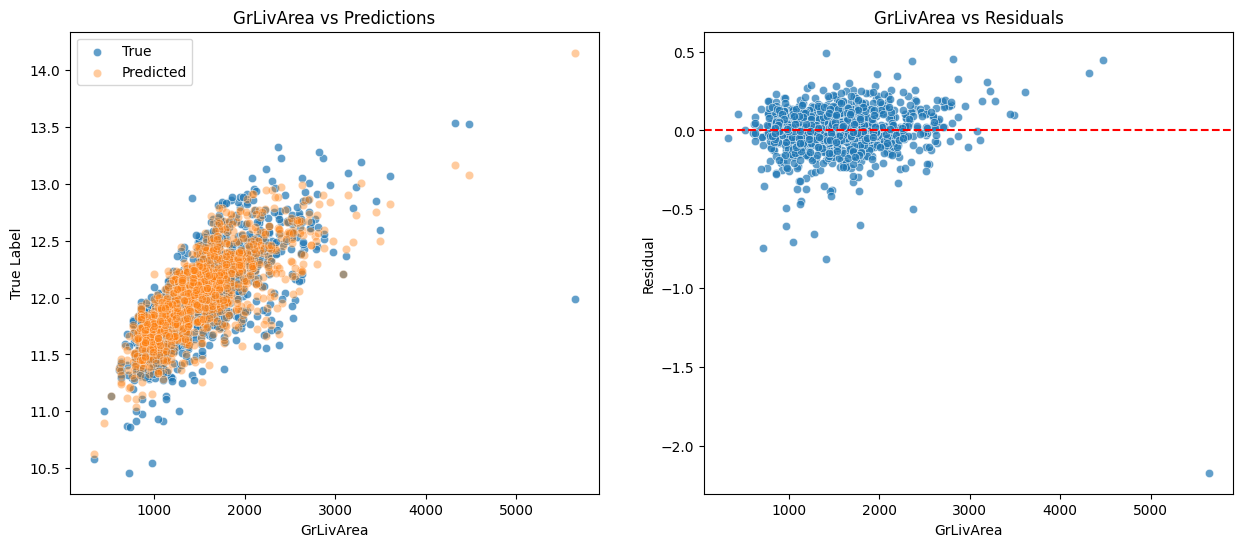

In [33]:
plot_predictions(train_set, y, lasso_oof, feature='GrLivArea')

The coefficients are a bit different, but we did not solved much. This was expected since we were not changing too much from the default.

We can make further use of the fact that we are working with a pipeline and directly apply it to the test set and see if the behavior changes.

C:\Users\Rapaglia\AppData\Local\Temp\ipykernel_9328\646231096.py:198: UserWarning: The dummies in this set do not match the ones in the train set, we corrected the issue.
  warnings.warn('The dummies in this set do not match the ones in the train set, we corrected the issue.',


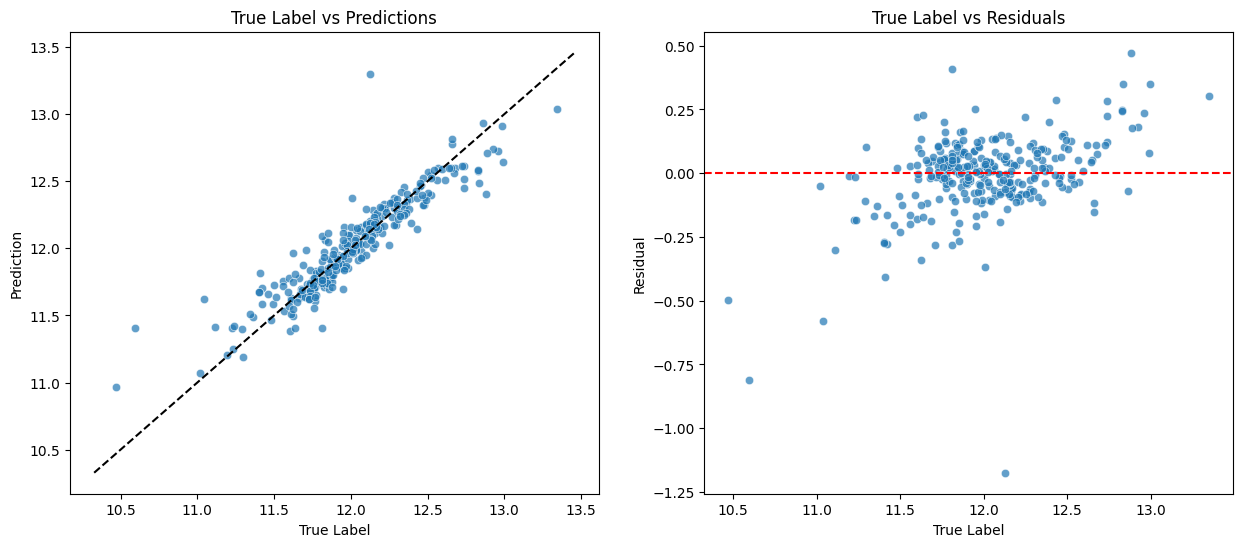

In [34]:
lasso_pred = lasso_pipe.predict(test_set)

plot_predictions(test_set, y_test, lasso_pred)

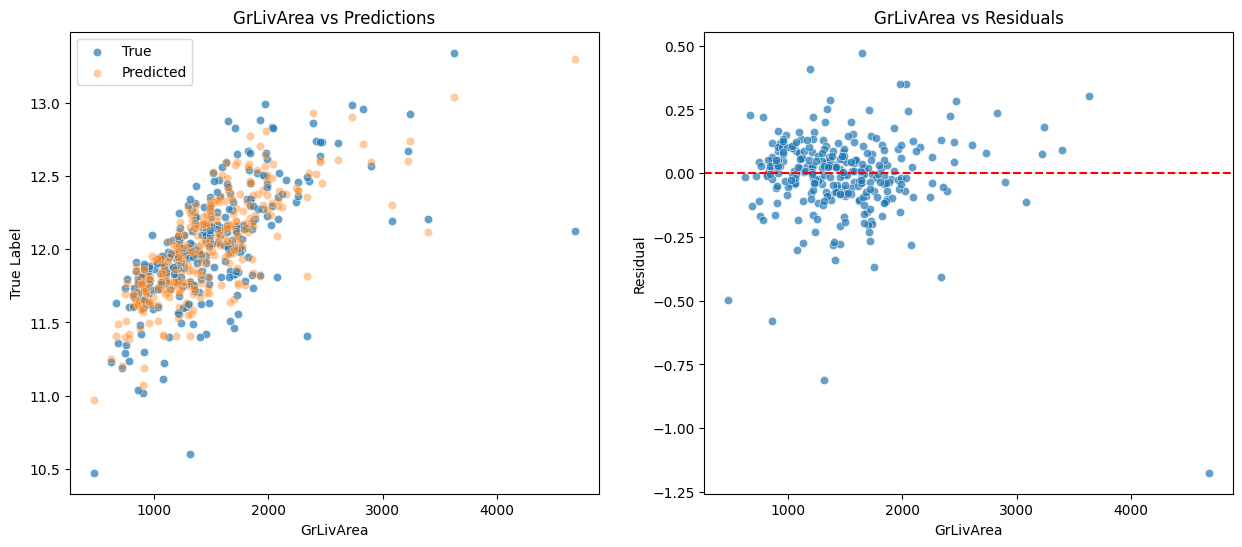

In [35]:
plot_predictions(test_set, y_test, lasso_pred, feature='GrLivArea')

For the fans of the numeric metrics

In [36]:
print('Score in 5-fold cv')
print(f'\tRMSE: {round(np.sqrt(mean_squared_error(y, lasso_oof)), 5)}')
print(f'\tMAE: {round(mean_absolute_error(np.expm1(y), np.expm1(lasso_oof)), 2)} dollars')
print('Score on holdout test')
print(f'\tRMSE: {round(np.sqrt(mean_squared_error(y_test, lasso_pred)), 5)}')
print(f'\tMAE: {round(mean_absolute_error(np.expm1(y_test), np.expm1(lasso_pred)), 2)} dollars')

Score in 5-fold cv
	RMSE: 0.14234
	MAE: 17629.44 dollars
Score on holdout test
	RMSE: 0.15512
	MAE: 18611.18 dollars


In [37]:
sub = df_test[['Id']].copy()

predictions = lasso_pipe.predict(df_test)

C:\Users\Rapaglia\AppData\Local\Temp\ipykernel_9328\646231096.py:198: UserWarning: The dummies in this set do not match the ones in the train set, we corrected the issue.
  warnings.warn('The dummies in this set do not match the ones in the train set, we corrected the issue.',


And we again have to put no effort to make our pipeline work on new data. This is important for 2 reasons:

we can put all our effort in making the model better rather than fighting with messy code
we are virtually ready to send our model to our client and it is ready to use